# 0-D Solid Rocket Motor (SRM) Model — Derivation

This notebook implements a **zero-dimensional (0-D)** internal ballistics model for a solid rocket motor that includes:

1. **Saint-Robert burn law** for propellant regression  
2. **Non-cylindrical grain geometry** via a tabulated function of web regression  
3. **Nozzle throat erosion**  
4. **Non-adiabatic wall heat losses**  
5. **Unsteady chamber pressure** derived from mass + energy balances + ideal gas law  

The model is formulated as an ODE system suitable for integration with `scipy.integrate.solve_ivp`.

<span style="color:red">In this model, propellant combustion and associated heat release is assumed to occur on the surface of the propellant and before the gas enters the model control volume.</span>

---

## 1. Control Volume and Assumptions

We consider the **gas in the combustion chamber** as a control volume (CV):

- Chamber pressure: $p(t)$  
- Chamber temperature: $T(t)$  
- Gas mass: $m(t)$  
- Chamber free volume: $V(t)$ — depends on **grain regression** $s(t)$  
- Propellant burn rate: $r_b(t)$  
- Burning surface area: $A_b(t)$  
- Nozzle throat area: $A_t(t)$  

### Mass Flows

- $\dot m_b(t)$: mass generated by propellant burning  
- $\dot m_e(t)$: mass exiting through the nozzle  

### Assumptions

- Gas is **well mixed** → spatially uniform $p(t), T(t)$ (0-D).  
- Combustion products behave as an **ideal gas** with constant $R, c_p, c_v$, and $\gamma = c_p/c_v$.  
- Inflow and outflow enthalpies approximated by chamber enthalpy.  
- Negligible kinetic energy inside CV.  
- No shaft work; only $p\,dV$ boundary work.  
- Optional: heat loss to walls.

---

## 2. Mass and Energy Balances

### 2.1 Mass Balance

The gas mass obeys:

$$
\frac{dm}{dt} = \dot m_b - \dot m_e
$$

---

### 2.2 Energy Balance

Total internal energy:

$$
U = m u = m c_v T
$$

Unsteady first law:

$$
\frac{d}{dt}(m c_v T)
= \dot m_b h_b - \dot m_e h_e - p \frac{dV}{dt} + \dot Q
$$

Under the well-stirred approximation: $h_b \approx h_e \approx c_p T$, so:

$$
\dot m_b h_b - \dot m_e h_e = c_p T(\dot m_b - \dot m_e) = c_p T \frac{dm}{dt}
$$

Expand LHS derivative:

$$
\frac{d}{dt}(m c_v T) = c_v\left(m\frac{dT}{dt} + T\frac{dm}{dt}\right)
$$

Substitute:

$$
c_v\left(m\frac{dT}{dt} + T\frac{dm}{dt}\right)
= c_p T \frac{dm}{dt} - p\frac{dV}{dt} + \dot Q
$$

Rearrange using $c_p - c_v = R$:

$$
\frac{dT}{dt}
= \frac{R T\frac{dm}{dt} - p\frac{dV}{dt} + \dot Q}{c_v m}
$$

---

## 3. Ideal Gas Law and Pressure Evolution

The ideal gas relation:

$$
pV = mRT
$$

Differentiate:

$$
\frac{dp}{dt}V + p\frac{dV}{dt}
= R\left(T\frac{dm}{dt} + m\frac{dT}{dt}\right)
$$

Substitute $dT/dt$ from the previous section and simplify. After algebra:

$$
\frac{dp}{dt}
= \gamma p\left(\frac{1}{m}\frac{dm}{dt} - \frac{1}{V}\frac{dV}{dt}\right)
+ \frac{\gamma - 1}{V}\dot Q
$$

Using $\frac{dm}{dt} = \dot m_b - \dot m_e$:

$$
\boxed{
\frac{dp}{dt}
= \gamma p\left[\frac{\dot m_b - \dot m_e}{m}
 - \frac{1}{V}\frac{dV}{dt} \right]
+ \frac{\gamma - 1}{V}\dot Q
}
$$

---

## 4. Saint-Robert Burn Law

Regression rate:

$$
r_b = a\,p^n
$$

Mass generation:

$$
\dot m_b = \rho_p\,r_b\,A_b(s)
= \rho_p\,a\,p^n\,A_b(s)
$$

---

## 5. Non-Cylindrical Grain Geometry via Web Regression $s(t)$

Regression distance:

$$
\frac{ds}{dt} = r_b = a\,p^n
$$

$A_b(s)$ and $V(s)$ are **geometry-dependent** and precomputed as tables.

By chain rule:

$$
\frac{dV}{dt} = \frac{dV}{ds}\frac{ds}{dt}
= \frac{dV}{ds}(s)\,a\,p^n
$$

This allows arbitrary grain shapes (star, finocyl, slotted, cruciform, etc.).

---

## 6. Nozzle Flow and Throat Erosion

### 6.1 Choked Mass Flow

For throat area $A_t = \pi r_t^2$:

$$
\dot m_e
= C_d A_t p\sqrt{\frac{\gamma}{RT}}
\left(\frac{2}{\gamma+1}\right)^{\frac{\gamma+1}{2(\gamma -1)}}
$$

### 6.2 Throat Erosion ODE

A simple erosion law:

$$
\frac{dr_t}{dt} = k_{\text{eros}}\left|\dot m_e\right|
$$

---

## 7. Wall Heat Loss (Non-Adiabatic)

Heat loss model:

$$
\dot Q = -h_w A_w(s)\,(T - T_w)
$$

where $A_w(s)$ is typically taken as $A_b(s)$ for simplicity.

Substitute into pressure equation:

$$
\frac{dp}{dt}
= \gamma p\left[\frac{\dot m_b - \dot m_e}{m}
 - \frac{1}{V}\frac{dV}{dt}\right]
+ \frac{\gamma - 1}{V}\left[-h_w A_w(s)(T - T_w)\right]
$$

---

## 8. Final ODE System

State:

$$
y(t) =
\begin{bmatrix}
p(t)\\
m(t)\\
s(t)\\
r_t(t)
\end{bmatrix}
$$

### Chamber pressure:

$$
\frac{dp}{dt}
= \gamma p\left[\frac{\dot m_b - \dot m_e}{m}
 - \frac{1}{V(s)}\frac{dV}{dt}\right]
+ \frac{\gamma - 1}{V(s)}\dot Q
$$

### Gas mass:

$$
\frac{dm}{dt} = \dot m_b - \dot m_e
$$

### Web regression:

$$
\frac{ds}{dt} = a\,p^n
$$

### Throat erosion:

$$
\frac{dr_t}{dt} = k_{\text{eros}}|\dot m_e|
$$

---

## 9. Notes for Implementation

- $A_b(s)$, $V(s)$, and $\frac{dV}{ds}(s)$ are obtained via interpolation from geometry tables.  
- Temperature always computed from ideal gas:

  $$
  T = \frac{p V}{mR}
  $$

- The system is integrated with:

  ```python
  solve_ivp(..., method="RK45", rtol=1e-6, atol=1e-9)

In [4]:
# Import the required modules
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # Retina display for plots

# 0-D SRM Model Python Implementation

In [5]:
# ----------------------------------------------------------------------
# Geometry: specify A_b(s) and V(s) for a non-cylindrical grain
# ----------------------------------------------------------------------
def build_geometry_table():
    """
    Example "non-cylindrical" grain geometry:
      - s: web burned from 0 to s_max
      - A_b(s): burning surface area that grows, peaks, then shrinks (star-like)
      - V(s): chamber volume that grows with s

    In practice, you'd generate A_b(s) and V(s) from CAD or analytical formulas
    for your actual grain geometry.
    """
    s_max = 0.05             # [m] maximum web regression
    N = 200
    s_tab = np.linspace(0.0, s_max, N)

    # Example baseline values
    A_b0 = 0.30              # [m^2] some nominal burning area
    V0 = 0.015               # [m^3] initial free volume
    dVds_nom = 0.10          # [m^2] effective growth of free volume per m of web

    # "Star-like" burning area profile: increases then decreases with s
    A_b_tab = A_b0 * (1.0 + 0.6 * np.sin(np.pi * s_tab / s_max))

    # Simple volume growth (could be more sophisticated)
    V_tab = V0 + dVds_nom * s_tab

    # Numerical derivative dV/ds
    dV_ds_tab = np.gradient(V_tab, s_tab)

    geom = {
        "s_tab": s_tab,
        "A_b_tab": A_b_tab,
        "V_tab": V_tab,
        "dV_ds_tab": dV_ds_tab,
        "s_min": float(s_tab[0]),
        "s_max": float(s_tab[-1]),
    }
    return geom


def geometry_from_s(s, geom):
    """
    Interpolate A_b(s), V(s), dV/ds from a geometry table.
    """
    # Clamp s into the tabulated range
    s_clamped = np.clip(s, geom["s_min"], geom["s_max"])
    A_b = np.interp(s_clamped, geom["s_tab"], geom["A_b_tab"])
    V = np.interp(s_clamped, geom["s_tab"], geom["V_tab"])
    dV_ds = np.interp(s_clamped, geom["s_tab"], geom["dV_ds_tab"])
    return A_b, V, dV_ds


# ----------------------------------------------------------------------
# ODE system
# ----------------------------------------------------------------------
def solid_motor_ode(t, y, params):
    """
    ODE system for a 0-D solid rocket motor with:
      - Saint-Robert burn law
      - Non-cylindrical grain via regression distance s(t)
      - Nozzle throat erosion
      - Non-adiabatic wall losses

    State vector y = [p, m, s, r_t]
      p   : chamber pressure [Pa]
      m   : gas mass in chamber [kg]
      s   : web regression distance [m]
      r_t : nozzle throat radius [m]
    """
    p, m, s, r_t = y

    # Unpack parameters
    gamma   = params["gamma"]        # [-]
    R       = params["R"]            # [J/kg/K]
    rho_p   = params["rho_p"]        # [kg/m^3]
    a_burn  = params["a_burn"]       # Saint-Robert 'a' [m/(Pa^n s)] or consistent
    n_burn  = params["n_burn"]       # Saint-Robert exponent [-]
    C_d     = params["C_d"]          # nozzle discharge coeff [-]
    h_w     = params["h_w"]          # wall heat transfer coeff [W/m^2/K]
    T_w     = params["T_w"]          # wall temperature [K]
    k_eros  = params["k_eros"]       # throat erosion coeff [m/(kg/s)]
    m_min   = params.get("m_min", 1e-6)
    geom    = params["geom"]         # geometry table dict

    # Get geometry from regression distance s
    A_b, V, dV_ds = geometry_from_s(s, geom)
    A_w = A_b  # assume burning surface == wall area for heat loss
    A_t = np.pi * r_t**2

    # Guard against zero / negative gas mass or volume
    m_eff = max(m, m_min)
    if V <= 0.0:
        V = 1e-9

    # Thermodynamics
    T = p * V / (m_eff * R)

    # Saint-Robert burn rate (ensure p >= 0)
    p_eff = max(p, 0.0)
    r_b = a_burn * (p_eff**n_burn)      # [m/s]

    # Mass generation from grain
    m_dot_b = rho_p * r_b * A_b         # [kg/s]

    # Nozzle mass flow (choked)
    if T <= 0.0:
        T = 1.0
    crit = (2.0 / (gamma + 1.0))**((gamma + 1.0) / (2.0*(gamma - 1.0)))
    m_dot_e = C_d * A_t * p * np.sqrt(gamma / (R*T)) * crit

    # Heat loss (negative if gas loses heat)
    Q_dot = - h_w * A_w * (T - T_w)     # [W = J/s]

    # Mass ODE
    dm_dt = m_dot_b - m_dot_e

    # Volume rate of change via chain rule
    dV_dt = dV_ds * r_b                 # [m^3/s]

    # Pressure ODE (from mass+energy+IG derivation)
    dp_dt = (
        gamma * p * ((m_dot_b - m_dot_e)/m_eff - dV_dt/V)
        + (gamma - 1.0) * Q_dot / V
    )

    # Grain regression ODE
    ds_dt = r_b

    # Throat erosion ODE
    dr_t_dt = k_eros * abs(m_dot_e)

    return [dp_dt, dm_dt, ds_dt, dr_t_dt]
# ----------------------------------------------------------------------

# 0-D Python Model Execution & Plotting

In [9]:
# Build geometry table for a notional non-cylindrical grain
geom = build_geometry_table()

# Model parameters (toy values; tune for your case)
params = {
    "gamma"  : 1.20,          # effective gamma
    "R"      : 300.0,         # J/kg/K
    "rho_p"  : 1700.0,        # kg/m^3
    "a_burn" : 5e-6,          # m/(Pa^n s)
    "n_burn" : 0.3,
    "C_d"    : 0.98,
    "h_w"    : 200.0,         # W/m^2/K
    "T_w"    : 500.0,         # K
    "k_eros" : 1e-8,          # m/(kg/s)
    "m_min"  : 1e-6,
    "geom"   : geom,
}

# Initial conditions
p0 = 2e6                       # Pa
T0 = 2500.0                     # K

# Use initial volume from geometry at s=0
A_b0, V0, dV_ds0 = geometry_from_s(0.0, geom)
m0 = p0 * V0 / (params["R"] * T0)

s0 = 0.0                       # m, initial regression
r_t0 = 0.02                    # m, initial throat radius

y0 = [p0, m0, s0, r_t0]

# Time span
t_span = (0.0, 5.0)            # seconds
t_eval = np.linspace(t_span[0], t_span[1], 600)

# Integrate
sol = solve_ivp(
    fun=lambda t, y: solid_motor_ode(t, y, params),
    t_span=t_span,
    y0=y0,
    t_eval=t_eval,
    method="RK45",
    rtol=1e-6,
    atol=1e-9,
)

t = sol.t
p = sol.y[0, :]
m = sol.y[1, :]
s = sol.y[2, :]
r_t = sol.y[3, :]


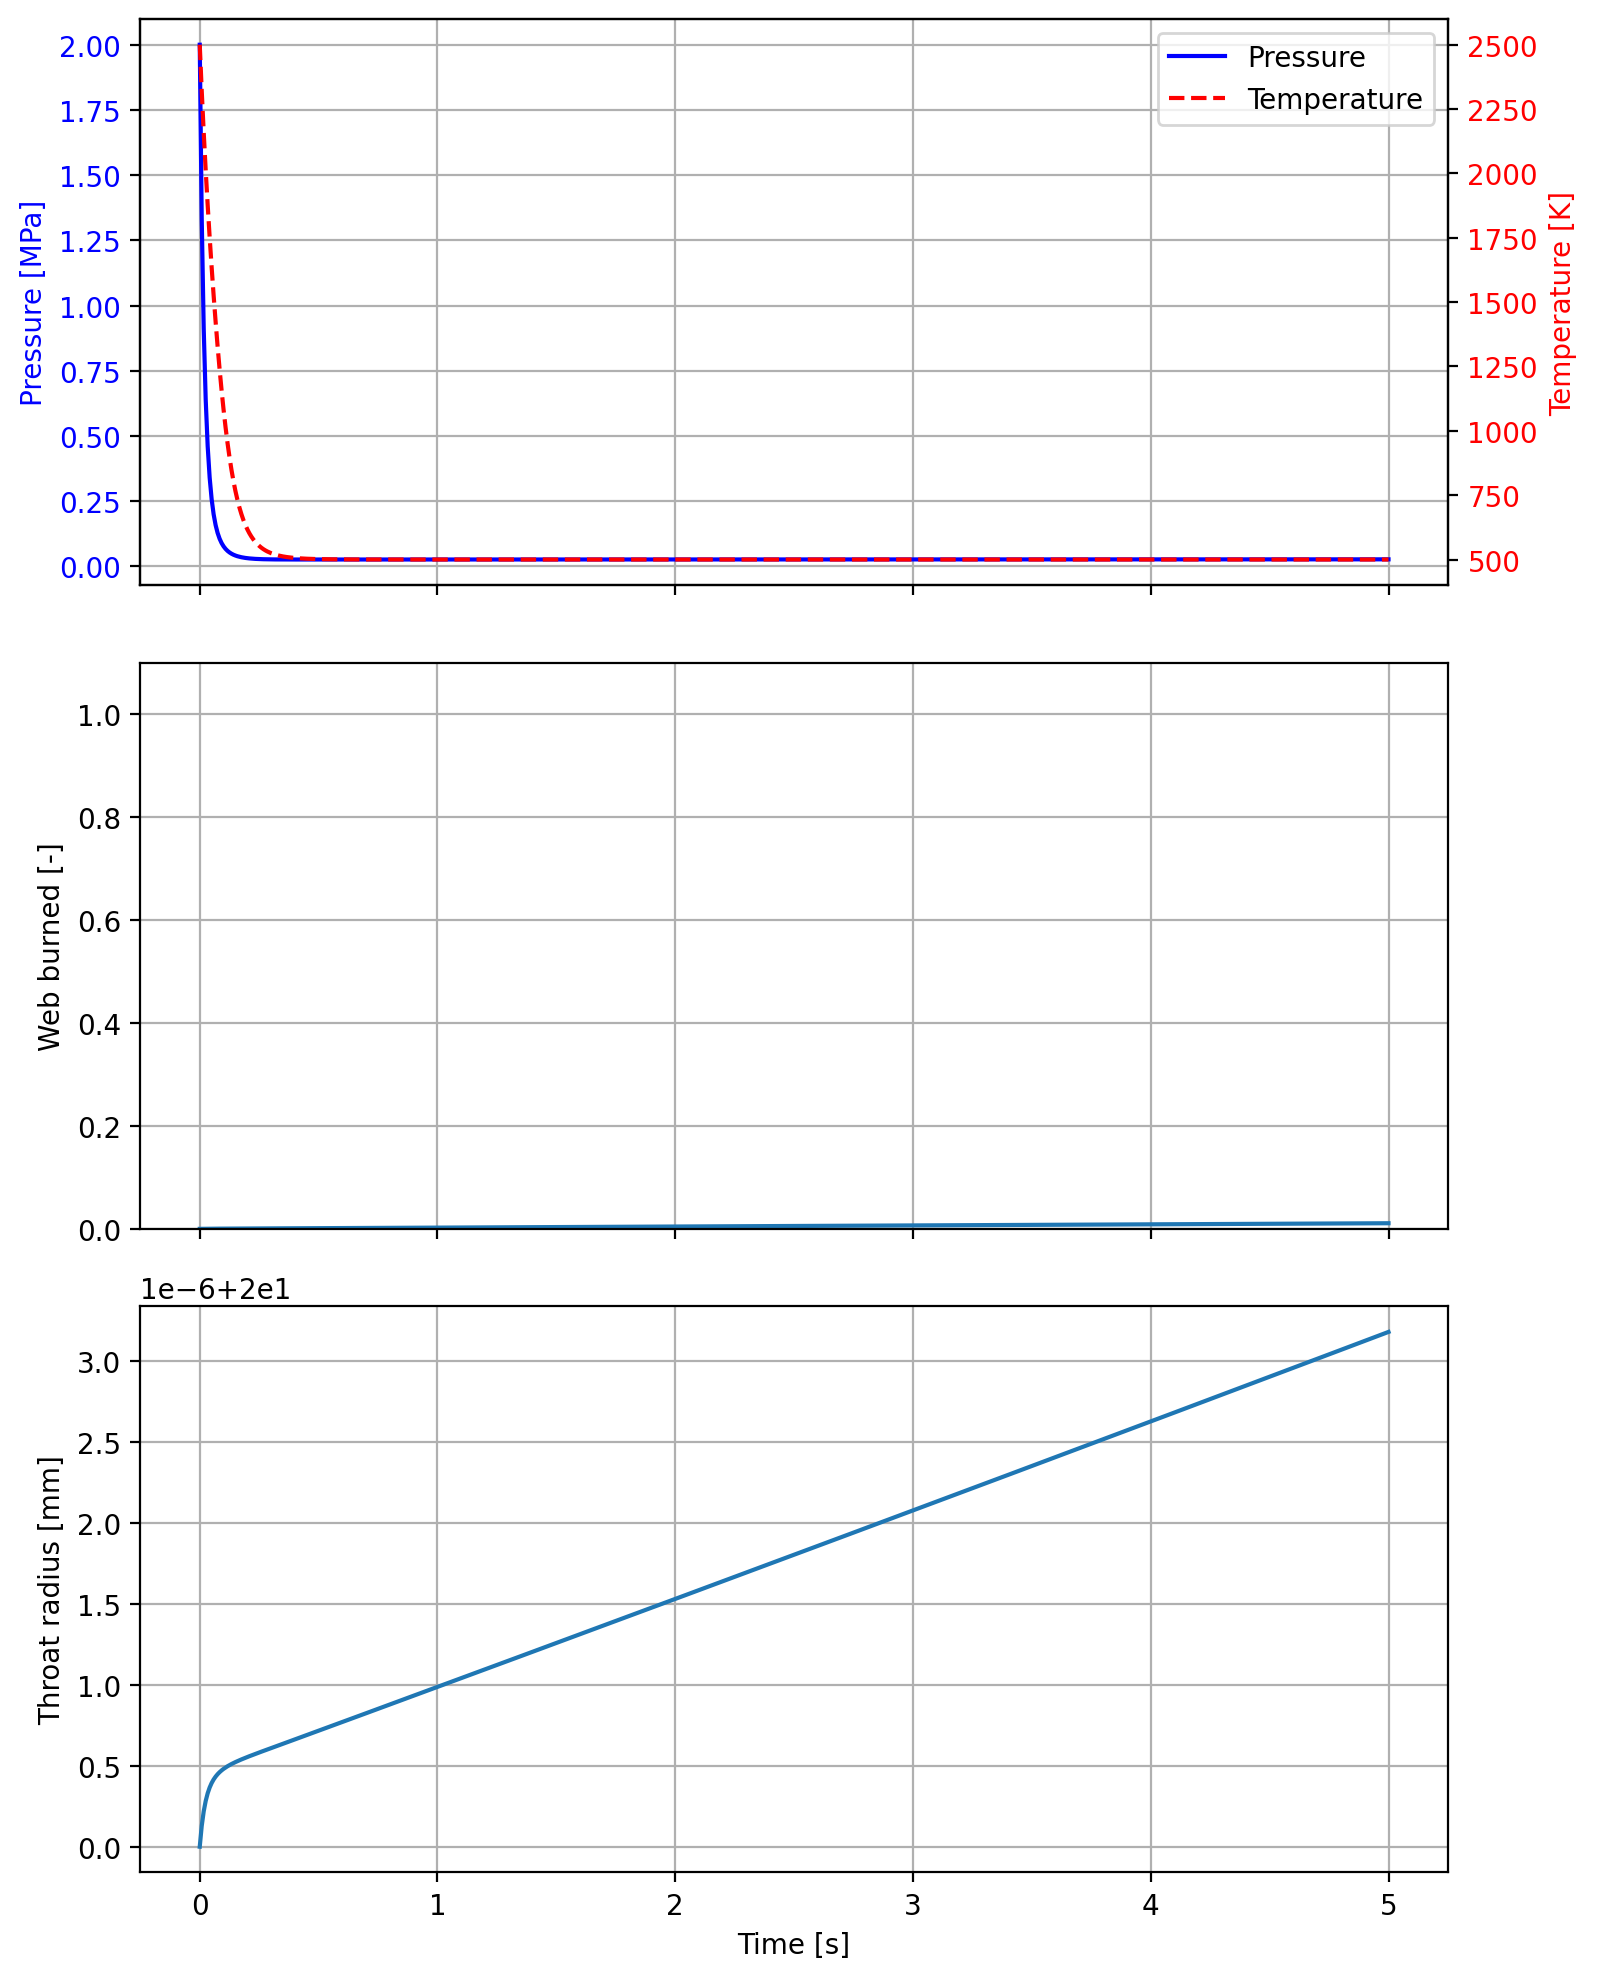

In [10]:
# ------------------------------------------------------------------
# Post-processing for plotting: compute T, mdot, etc.
# ------------------------------------------------------------------
T = np.zeros_like(t)
m_dot_b = np.zeros_like(t)
m_dot_e = np.zeros_like(t)

for i, (ti, pi, mi, si, rti) in enumerate(zip(t, p, m, s, r_t)):
    A_bi, Vi, dV_dsi = geometry_from_s(si, geom)
    mi_eff = max(mi, params["m_min"])
    Ti = pi * Vi / (mi_eff * params["R"])
    T[i] = Ti

    # Burn rate and mass flows
    p_eff = max(pi, 0.0)
    r_bi = params["a_burn"] * (p_eff**params["n_burn"])
    m_dot_b[i] = params["rho_p"] * r_bi * A_bi

    A_ti = np.pi * rti**2
    if Ti <= 0:
        Ti = 1.0
    crit = (2.0 / (params["gamma"] + 1.0))**(
        (params["gamma"] + 1.0)/(2.0*(params["gamma"] - 1.0))
    )
    m_dot_e[i] = params["C_d"] * A_ti * pi * np.sqrt(params["gamma"]/(params["R"]*Ti)) * crit

# Normalize regression by max web
s_max = geom["s_max"]
s_frac = s / s_max

# ------------------------------------------------------------------
# Plotting
# ------------------------------------------------------------------
fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# Chamber pressure & temperature
axs[0].plot(t, p/1e6, 'b-', label="Pressure")
ax2 = axs[0].twinx()
ax2.plot(t, T, 'r--', label="Temperature")
ax2.set_ylabel("Temperature [K]", color='r')
ax2.tick_params(axis='y', labelcolor='r')
axs[0].set_ylabel("Pressure [MPa]", color='b')
axs[0].tick_params(axis='y', labelcolor='b')
# Combine the legends
lines, labels = axs[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axs[0].legend(lines + lines2, labels + labels2, loc='upper right')
axs[0].grid(True)

# Web regression fraction
axs[1].plot(t, s_frac)
axs[1].set_ylabel("Web burned [-]")
axs[1].set_ylim(0, 1.1)
axs[1].grid(True)

# Throat radius
axs[2].plot(t, r_t*1000.0)
axs[2].set_ylabel("Throat radius [mm]")
axs[2].set_xlabel("Time [s]")
axs[2].grid(True)

plt.tight_layout()
plt.show()